In [1]:
!wget https://github.com/Woffee/genetic-programming/raw/master/lisa.jpg

from PIL import Image

--2020-10-07 03:30:52--  https://github.com/Woffee/genetic-programming/raw/master/lisa.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Woffee/genetic-programming/master/lisa.jpg [following]
--2020-10-07 03:30:52--  https://raw.githubusercontent.com/Woffee/genetic-programming/master/lisa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4248 (4.1K) [image/jpeg]
Saving to: ‘lisa.jpg.1’

lisa.jpg.1          100%[===================>]   4.15K  --.-KB/s    in 0s      

2020-10-07 03:30:52 (41.3 MB/s) - ‘lisa.jpg.1’ saved [4248/4248]



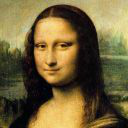

In [2]:
TARGET_IMG_NAME = 'lisa.jpg'  # target image file name
POP_SIZE = 25                 # population size
MUT_RATE = 0.05               # mutation rate
GENERATIONS = 100000          # number of generations
CHILDREN_PER_GEN = 5          # children generated in each generations
TRI_NUM = 100                 # number of triangles
BACKGROUND_COLOR = 'white'    # background color
IMG_WIDTH = 128

# load target image and resize
TARGET = Image.open(TARGET_IMG_NAME).convert('RGB')
TARGET = TARGET.resize((IMG_WIDTH, IMG_WIDTH))
TARGET

In [3]:
import random
import matplotlib.pyplot as plt

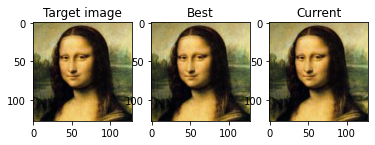

In [4]:
# test matplotlib

fig=plt.figure(figsize=(6, 18))

ax = fig.add_subplot(1, 3, 1)
ax.set_title("Target image")
plt.imshow(TARGET)

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Best")
plt.imshow(TARGET)

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Current")
plt.imshow(TARGET)

plt.show()

In [5]:
class gene(object):
    """
    The gene class, which represent a triangle.

    Attributes:
        pos_1: The first vertex of the triangle.
        pos_2: The second vertex of the triangle.
        pos_2: The third vertex of the triangle.
        color: The GRBA value of the triangle.
    """
    def __init__(self):
        """
        Inits a gene with mutation operation.
        """
        self.mutate()

    def mutate(self):
        """
        Mutation operation. Change the values of a gene.
        """
        self.pos_1 = (random.randint(0, 500), random.randint(0, 500))
        self.pos_2 = (random.randint(0, 500), random.randint(0, 500))
        self.pos_3 = (random.randint(0, 500), random.randint(0, 500))
        self.color = {'r': random.randint(0, 255),
                      'g': random.randint(0, 255),
                      'b': random.randint(0, 255),
                      'a': 128}

In [6]:
class genetic(object):
    """
    The genetic operation utils class.
    """
    def crossover(self, parent_1, parent_2, rate):
        """
        Crossover method 1, one-point crossover. (legacy)
        Generate a child with a portion of complete genes from parent_1
        and another portion of complete genes from parent_2.

        Args:
            parent_1: a parent.
            parent_2: another parent.
            rate: the portion of genes that come from parent_1.

        Returns:
            new_genes: a list of new genes.
        """
        gene_num = len(parent_1.genes)
        mid = int(gene_num * rate)
        new_genes = parent_1.genes[:mid] + parent_2.genes[mid:]
        return new_genes

    def crossover2(self, parent_1, parent_2, tri_num):
        """
        Crossover method 2, uniform crossover. (legacy)
        Generate a child with some complete genes from parent_1
        and some complete genes from parent_2.

        Args:
            parent_1: a parent.
            parent_2: another parent.
            tri_num: number of triangles that form the result image.

        Returns:
            new_genes: a list of new genes.
        """
        new_genes = []
        for i in xrange(tri_num):
            if random.uniform(0, 1) < 0.5:
                new_genes.append(parent_1.genes[i])  # get gene from parent_1
            else:
                new_genes.append(parent_2.genes[i])  # get gene from parent_2
        return new_genes

    def crossover3(self, parent_1, parent_2, tri_num):
        """
        Crossover method 3, uniform crossover. (currently used)
        Transform the parent genes into array representation(DNA sequence).
        The child get a portion of DNA from parent_1, then from parent_2,
        then from parent_1 again, and so on.

        Args:
            parent_1: a parent.
            parent_2: another parent.
            tri_num: number of triangles that form the result image.

        Returns:
            new_genes: an array representation(DNA sequence) of the gene.
        """
        array1 = parent_1.get_array()
        array2 = parent_2.get_array()
        new_array = []
        flag = -1
        last_pos = 0
        pos = random.randint(0, 50)
        while last_pos < tri_num * 6:
            if flag > 0:
                new_array += array1[last_pos:pos]
            else:
                new_array += array2[last_pos:pos]
            flag *= -1
            last_pos = pos
            pos = random.randint(last_pos, last_pos+50)
        return new_array

    def mutate(self, genes, rate, tri_num):
        """
        Mutation Selector:
        Select some genes and let them mutate.

        Args:
            genes: the list of genes of an individual.
            rate: the mutation rate.
            tri_num: number of triangles that form the result image.

        Returns:
            genes: a list of mutated genes.
        """
        if random.uniform(0, 1) < rate:
            mut_genes = random.sample(range(tri_num), 5)
            for g in mut_genes:
                genes[g].mutate()
        return genes

In [7]:
import math
import operator
from PIL import Image, ImageDraw, ImageChops
from functools import reduce

In [8]:

class individual(object):
    """
    The individual class, which is an image.

    Attributes:
        genes: all the genes(triangles).
        im: the actual image file.
        fitness: the fitness, the lower the better
    """
    def __init__(self, parent_1=None, parent_2=None):
        """
        Inits an individual.
        If it has parents, generate its genes via crossover operation.
        If not, generate its genes randomly.

        Args:
            parent_1: a parent.
            parent_2: another parent.
        """
        self.genes = []
        op = genetic()
        if parent_1 and parent_2:
            array = op.crossover3(parent_1, parent_2, TRI_NUM)
            self.generate_genes_from_array_with_mut(array, MUT_RATE)
        else:
            for i in range(TRI_NUM):
                self.genes.append(gene())
        # set actual image
        self.im = self.get_current_img()
        # calculate fitness
        self.fitness = self.get_fitness(TARGET)

    def get_current_img(self):
        """
        Get actual image file using the properties of the triangles.

        Important: set canvas to RGB, draw object to RGBA.

        Returns:
            im: the image file.
        """
        im = Image.new('RGB', (IMG_WIDTH, IMG_WIDTH), BACKGROUND_COLOR)
        draw = ImageDraw.Draw(im, 'RGBA')
        for gene in self.genes:
            draw.polygon([gene.pos_1, gene.pos_2, gene.pos_3],
                         fill=(gene.color['r'], gene.color['g'],
                               gene.color['b'], gene.color['a']))
        del draw
        return im

    def save_current_img(self, f_name):
        """
        Save image to a file.

        Args:
            f_name: saved file name.
        """
        self.im.save(f_name, 'PNG')

    def get_fitness(self, target):
        """
        Get fitness of the individual.
        This was calculated by RMS distance of histograms.

        Args:
            target: target image.

        Returns:
            the fitness value.
        """
        h = ImageChops.difference(target, self.im).histogram()
        return math.sqrt(reduce(operator.add,
                         map(lambda h, i: h*(i**2),
                             h, list(range(256))*3)) /
                            (float(target.size[0]) * target.size[1]))

    def get_array(self):
        """
        Get array representation(DNA sequence) of the genes.

        Returns:
            array: DNA sequence.
        """
        array = []
        for g in self.genes:
            array.append(g.pos_1)
            array.append(g.pos_2)
            array.append(g.pos_3)
            array.append(g.color['r'])
            array.append(g.color['g'])
            array.append(g.color['b'])
        return array

    def generate_genes_from_array_with_mut(self, array, rate):
        """
        Transform DNA sequence into a list of genes,
        plus a mutation.

        Args:
            array: DNA sequence.
            rate: mutation rate.
        """
        new_array = zip(*[iter(array)]*6)
        self.genes = []
        for chunk in new_array:
            g = gene()
            if random.uniform(0, 1) > rate:
                g.pos_1 = chunk[0]
                g.pos_2 = chunk[1]
                g.pos_3 = chunk[2]
                g.color['r'] = chunk[3]
                g.color['g'] = chunk[4]
                g.color['b'] = chunk[5]
            self.genes.append(g)

In [9]:
def initialize(pop):
    """
    Inits population.

    Args:
        pop: population.

    Returns:
        pop: population.
    """
    for i in range(POP_SIZE*2):
        pop.append(individual())
    pop.sort(key=lambda x: x.fitness)
    pop = pop[:POP_SIZE]
    return pop


In [15]:
from IPython.display import clear_output

In [20]:
def evolve(pop):
    """
    Evolve population.

    Args:
        pop: population.

    Returns:
        pop: population.
    """
    for i in range(GENERATIONS):

        children = []
        # generate weighed choices according to fitness
        parent_choices = []
        w = 100
        for p in pop:
            parent_choices.append((p, w))
            if w > 0:
                w = w - 10
        pop_choices = [val for val, cnt in parent_choices for j in range(cnt)]
        # generate children
        for j in range(CHILDREN_PER_GEN):
            parent_1 = random.choice(pop_choices)
            parent_2 = random.choice(pop_choices)
            child = individual(parent_1, parent_2)
            children.append(child)
        # compare and save new individuals
        pop += children
        pop.sort(key=lambda x: x.fitness)
        pop = pop[:POP_SIZE]
        # print log info
        if i % 10000 == 0 or i in [100, 200, 500, 1000, 5000]:
            pop[0].save_current_img(str(i)+'_b.png')  # save intermediate imgs
        # if i % 10 == 0:
            # print current best fitness and avg fitness
            # avg = sum(map(lambda x: x.fitness, pop)) / 25
            
        if i % 100 == 0:
            clear_output()
            avg = sum(map(lambda x: x.fitness, pop)) / 25
            print("Finish " + str(i), pop[0].fitness, avg)
            
            fig=plt.figure(figsize=(6, 18))
            ax = fig.add_subplot(1, 2, 1)
            ax.set_title("Target image")
            plt.imshow(TARGET)

            ax = fig.add_subplot(1, 2, 2)
            ax.set_title("Current")
            plt.imshow(pop[0].im)

            plt.show()
    return pop


Finish 99900 66.48355151517038 66.48775203186545


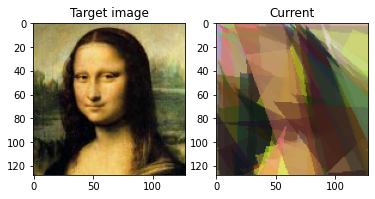

66.4835290229667


In [21]:
pop = []
pop = initialize(pop)
pop = evolve(pop)
pop[0].save_current_img('best.png')
print(pop[0].fitness)